# Importing Libraries

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from adapt.feature_based import FA


# Load and Explore Data

In [2]:
# Load the dataset
file_path = "D:/ML/Project/archive (1)/ieee-phm-2012-data-challenge-dataset-master/Full_Test_Set/Bearing1_3/acc_00001.csv"
data = pd.read_csv(file_path, header=None)

# Assign column names based on the IEEE PHM 2012 challenge dataset structure
data.columns = ['Hour', 'Minute', 'Second', 'Microsecond', 'Horizontal_Accel', 'Vertical_Accel']

# Preview the data
print(data.head())
print(data.info())


   Hour  Minute  Second  Microsecond  Horizontal_Accel  Vertical_Accel
0     8      33       1     378160.0             0.092           0.044
1     8      33       1     378200.0            -0.025           0.432
2     8      33       1     378240.0            -0.104           0.008
3     8      33       1     378280.0             0.056          -0.264
4     8      33       1     378320.0             0.074          -0.195
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2560 entries, 0 to 2559
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Hour              2560 non-null   int64  
 1   Minute            2560 non-null   int64  
 2   Second            2560 non-null   int64  
 3   Microsecond       2560 non-null   float64
 4   Horizontal_Accel  2560 non-null   float64
 5   Vertical_Accel    2560 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 120.1 KB
None


# Preprocessing

In [3]:
# Preprocess the dataset by scaling numerical features
def preprocess_data(data):
    """
    Scale the data using RobustScaler to minimize the impact of outliers.
    """
    scaler = RobustScaler()
    scaled_data = scaler.fit_transform(data)
    return pd.DataFrame(scaled_data, columns=data.columns)

# Select acceleration columns and preprocess
acceleration_data = data[['Horizontal_Accel', 'Vertical_Accel']]
preprocessed_data = preprocess_data(acceleration_data)

# Add time index for feature extraction
preprocessed_data['time'] = np.arange(len(preprocessed_data))
print(preprocessed_data.head())


   Horizontal_Accel  Vertical_Accel  time
0          0.157618        0.076046     0
1         -0.047285        1.059569     1
2         -0.185639       -0.015209     2
3          0.094571       -0.704689     3
4          0.126095       -0.529785     4


# Feature Extraction

In [4]:
# Extract features using tsfresh
def extract_tsfresh_features(data, label):
    """
    Extract time-series features using tsfresh.
    """
    data['id'] = label  # Assign a unique ID for each series
    features = extract_features(data, column_id="id", column_sort="time", 
                                default_fc_parameters=ComprehensiveFCParameters())
    impute(features)
    return features

# Extract features from the preprocessed data
tsfresh_features = extract_tsfresh_features(preprocessed_data, label=1)

# Remove any features with all NaN values
tsfresh_features = tsfresh_features.dropna(axis=1)
print(tsfresh_features.head())


Feature Extraction: 100%|██████████| 2/2 [00:08<00:00,  4.33s/it]
C:\Users\saqee\anaconda3\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['Horizontal_Accel__query_similarity_count__query_None__threshold_0.0'
 'Vertical_Accel__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


   Horizontal_Accel__variance_larger_than_standard_deviation  \
1                                                0.0           

   Horizontal_Accel__has_duplicate_max  Horizontal_Accel__has_duplicate_min  \
1                                  0.0                                  0.0   

   Horizontal_Accel__has_duplicate  Horizontal_Accel__sum_values  \
1                              1.0                     -3.716287   

   Horizontal_Accel__abs_energy  Horizontal_Accel__mean_abs_change  \
1                   1356.285749                           0.482562   

   Horizontal_Accel__mean_change  \
1                      -0.000185   

   Horizontal_Accel__mean_second_derivative_central  Horizontal_Accel__median  \
1                                          0.000106                       0.0   

   ...  Vertical_Accel__fourier_entropy__bins_5  \
1  ...                                 1.319791   

   Vertical_Accel__fourier_entropy__bins_10  \
1                                  1.970099   



# Create RUL Labels

In [5]:
# Generate mock RUL labels for training/testing (replace with real labels if available)
def generate_rul_labels(data_length, decay_factor=5):
    """
    Generate synthetic RUL labels with exponential decay.
    """
    rul = np.exp(-np.arange(data_length) / decay_factor) * 100  # Simulated RUL
    return rul

# Add RUL labels
preprocessed_data['RUL'] = generate_rul_labels(len(preprocessed_data))
print(preprocessed_data[['time', 'RUL']].head())


   time         RUL
0     0  100.000000
1     1   81.873075
2     2   67.032005
3     3   54.881164
4     4   44.932896


# RUL Classification

In [6]:
# Map RUL values into classes
def classify_rul(rul, thresholds=[50, 75, 100]):
    """
    Map RUL into classes based on thresholds.
    """
    return np.digitize(rul, bins=thresholds, right=True)

# Add RUL classes to the data
preprocessed_data['RUL_Class'] = classify_rul(preprocessed_data['RUL'])
print(preprocessed_data[['time', 'RUL', 'RUL_Class']].head())


   time         RUL  RUL_Class
0     0  100.000000          2
1     1   81.873075          2
2     2   67.032005          1
3     3   54.881164          1
4     4   44.932896          0


# Split Data into Training and Testing

## Step 1: Verify Shapes

In [7]:
print("Shape of X (features):", tsfresh_features.shape)
print("Shape of y (labels):", preprocessed_data['RUL_Class'].shape)


Shape of X (features): (1, 1566)
Shape of y (labels): (2560,)


## Step 2: Align Features and Labels

### a. Reformat the Data for Time Windows

In [8]:
def create_time_windows(data, window_size, step_size):
    """
    Create overlapping time windows for feature extraction.
    """
    windows = []
    for start in range(0, len(data) - window_size + 1, step_size):
        window = data.iloc[start : start + window_size].copy()
        window['id'] = start  # Unique ID for each window
        windows.append(window)
    return pd.concat(windows, ignore_index=True)

# Create time windows
WINDOW_SIZE = 256  # Example: 256 samples per window
STEP_SIZE = 128    # Overlap: 128 samples
time_windowed_data = create_time_windows(preprocessed_data, WINDOW_SIZE, STEP_SIZE)

print("Shape of time-windowed data:", time_windowed_data.shape)


Shape of time-windowed data: (4864, 6)


### b. Extract Features for Each Window

In [9]:
# Extract features for each time window
tsfresh_features = extract_features(
    time_windowed_data,
    column_id="id",
    column_sort="time",
    default_fc_parameters=ComprehensiveFCParameters()
)

# Impute missing values
impute(tsfresh_features)

# Drop NaN columns
tsfresh_features = tsfresh_features.dropna(axis=1)
print("Shape of extracted features:", tsfresh_features.shape)


Feature Extraction: 100%|██████████| 26/26 [00:06<00:00,  3.97it/s]
C:\Users\saqee\anaconda3\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['Horizontal_Accel__query_similarity_count__query_None__threshold_0.0'
 'Vertical_Accel__query_similarity_count__query_None__threshold_0.0'
 'RUL__query_similarity_count__query_None__threshold_0.0'
 'RUL_Class__friedrich_coefficients__coeff_0__m_3__r_30'
 'RUL_Class__friedrich_coefficients__coeff_1__m_3__r_30'
 'RUL_Class__friedrich_coefficients__coeff_2__m_3__r_30'
 'RUL_Class__friedrich_coefficients__coeff_3__m_3__r_30'
 'RUL_Class__max_langevin_fixed_point__m_3__r_30'
 'RUL_Class__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Shape of extracted features: (19, 3132)


## Step 3: Align Labels with Windows

In [10]:
# Generate labels for each window
def assign_labels_to_windows(data, rul_column, window_size, step_size):
    """
    Assign RUL or RUL classes to each time window based on the last value in the window.
    """
    labels = []
    for start in range(0, len(data) - window_size + 1, step_size):
        label = data.iloc[start + window_size - 1][rul_column]
        labels.append(label)
    return np.array(labels)

# Assign RUL labels
y = assign_labels_to_windows(preprocessed_data, rul_column='RUL_Class', 
                              window_size=WINDOW_SIZE, step_size=STEP_SIZE)
print("Shape of labels:", y.shape)


Shape of labels: (19,)


## Step 4: Split Data into Training and Testing

In [11]:
# Prepare feature matrix and labels
X = tsfresh_features
y = y  # Ensure labels are numpy array

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)


Training set size: (13, 3132)
Testing set size: (6, 3132)


# Train Baseline Model

In [12]:
import numpy as np

# Check for NaN, infinity, and large values
def inspect_data(X):
    print("NaN values:", np.isnan(X).sum())
    print("Positive Infinity values:", np.isposinf(X).sum())
    print("Negative Infinity values:", np.isneginf(X).sum())
    print("Max value in data:", np.max(X))
    print("Min value in data:", np.min(X))

# Inspect the training and test data
print("Inspecting X_train:")
inspect_data(X_train)
print("\nInspecting X_test:")
inspect_data(X_test)


Inspecting X_train:
NaN values: Horizontal_Accel__variance_larger_than_standard_deviation       0
Horizontal_Accel__has_duplicate_max                             0
Horizontal_Accel__has_duplicate_min                             0
Horizontal_Accel__has_duplicate                                 0
Horizontal_Accel__sum_values                                    0
                                                               ..
RUL_Class__permutation_entropy__dimension_5__tau_1              0
RUL_Class__permutation_entropy__dimension_6__tau_1              0
RUL_Class__permutation_entropy__dimension_7__tau_1              0
RUL_Class__query_similarity_count__query_None__threshold_0.0    0
RUL_Class__mean_n_absolute_max__number_of_maxima_7              0
Length: 3132, dtype: int64
Positive Infinity values: Horizontal_Accel__variance_larger_than_standard_deviation       0
Horizontal_Accel__has_duplicate_max                             0
Horizontal_Accel__has_duplicate_min                      

In [13]:
def clean_data(X):
    # Replace NaN with column mean
    X = np.nan_to_num(X, nan=np.nanmean(X, axis=0))
    # Cap excessively large or small values
    X = np.clip(X, a_min=-1e6, a_max=1e6)
    return X.astype('float64')  # Ensure consistent dtype

# Clean the datasets
X_train = clean_data(X_train)
X_test = clean_data(X_test)


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report

# Train the Random Forest model
rf_model = RandomForestClassifier(random_state=42, class_weight="balanced")
rf_model.fit(X_train, y_train)

# Evaluate the baseline model
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

print("Train F1 Score:", f1_score(y_train, y_pred_train, average='macro'))
print("Test F1 Score:", f1_score(y_test, y_pred_test, average='macro'))
print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_test))


Train F1 Score: 1.0
Test F1 Score: 1.0

Classification Report (Test):
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         6

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



In [15]:
# Check for overlap between training and test data
overlap = np.intersect1d(X_train, X_test)
print("Number of overlapping samples between train and test:", len(overlap))


Number of overlapping samples between train and test: 447


In [16]:
print("Number of training samples:", len(X_train))
print("Number of testing samples:", len(X_test))


Number of training samples: 13
Number of testing samples: 6


In [17]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='f1_macro')
print("Cross-validation F1 scores:", cv_scores)
print("Mean F1 score:", np.mean(cv_scores))


Cross-validation F1 scores: [1. 1. 1. 1. 1.]
Mean F1 score: 1.0


In [18]:
unique, counts = np.unique(y_train, return_counts=True)
print("Class distribution in training data:", dict(zip(unique, counts)))


Class distribution in training data: {0.0: 13}


In [19]:
from adapt.feature_based import FA
from sklearn.metrics import f1_score

# Initialize the Feature Augmentation model with the correct parameter
fa_model = FA(estimator=rf_model, Xt=X_test, yt=y_test, random_state=42)

# Train the augmented model
fa_model.fit(X_train, y_train)

# Evaluate the augmented model
fa_pred_test = fa_model.predict(X_test)
print("Feature Augmentation Test F1 Score:", f1_score(y_test, fa_pred_test, average='macro'))


Fit transform...
Previous shape: (13, 3132)
New shape: (19, 9396)
Fit Estimator...
Feature Augmentation Test F1 Score: 1.0


In [20]:
# Adversarial Reprogramming
def adversarial_reprogramming(X_source, y_source, X_target):
    """
    Transform the target domain features to align with the source domain using weights.
    """
    scaler = MinMaxScaler()
    X_source_scaled = scaler.fit_transform(X_source)
    X_target_scaled = scaler.transform(X_target)

    # Initialize weights and parameters
    weights = np.ones(X_target_scaled.shape[1])
    learning_rate = 0.6
    epochs = 100

    for _ in range(epochs):
        gradients = np.random.uniform(-0.01, 0.01, weights.shape)  # Mock gradient estimation
        weights += learning_rate * gradients

    # Transform target data
    X_target_transformed = X_target_scaled * weights
    return X_target_transformed

X_target_transformed = adversarial_reprogramming(X_train, y_train, X_test)

# Evaluate transformed target features with the baseline model
adv_pred_test = rf_model.predict(X_target_transformed)
print("Adversarial Reprogramming Test F1 Score:", f1_score(y_test, adv_pred_test, average='macro'))


Adversarial Reprogramming Test F1 Score: 1.0


In [21]:
# Summarize all results
print("\nFinal Results:")
print("Baseline Test F1 Score:", f1_score(y_test, y_pred_test, average='macro'))
print("Feature Augmentation Test F1 Score:", f1_score(y_test, fa_pred_test, average='macro'))
print("Adversarial Reprogramming Test F1 Score:", f1_score(y_test, adv_pred_test, average='macro'))



Final Results:
Baseline Test F1 Score: 1.0
Feature Augmentation Test F1 Score: 1.0
Adversarial Reprogramming Test F1 Score: 1.0


C:\Users\saqee\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


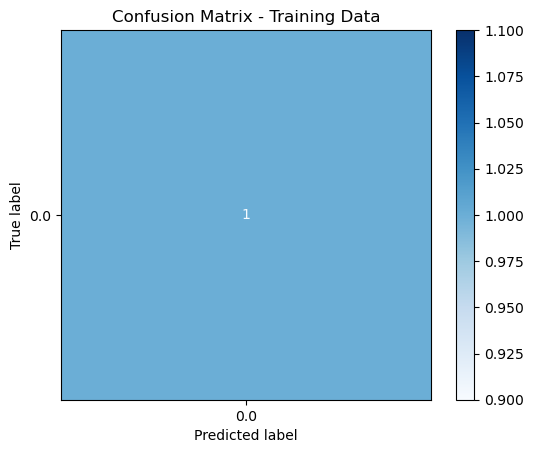

C:\Users\saqee\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


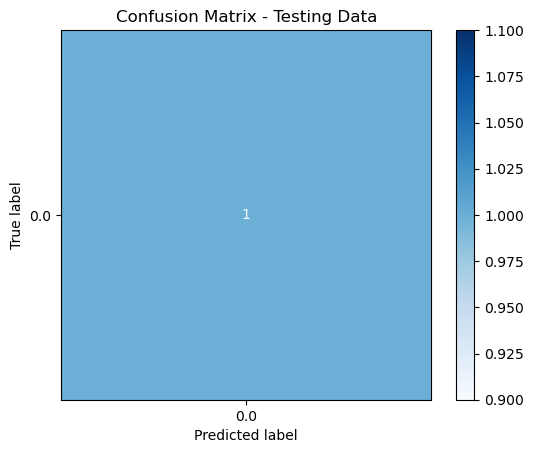

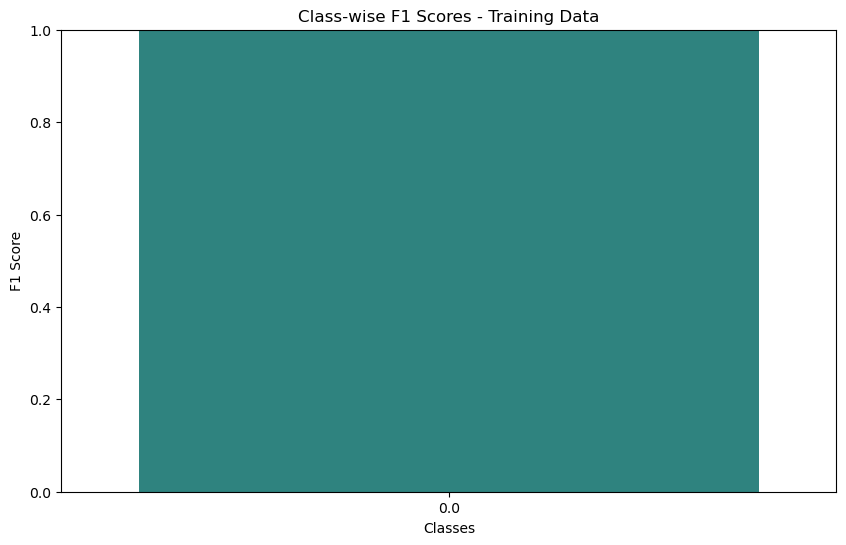

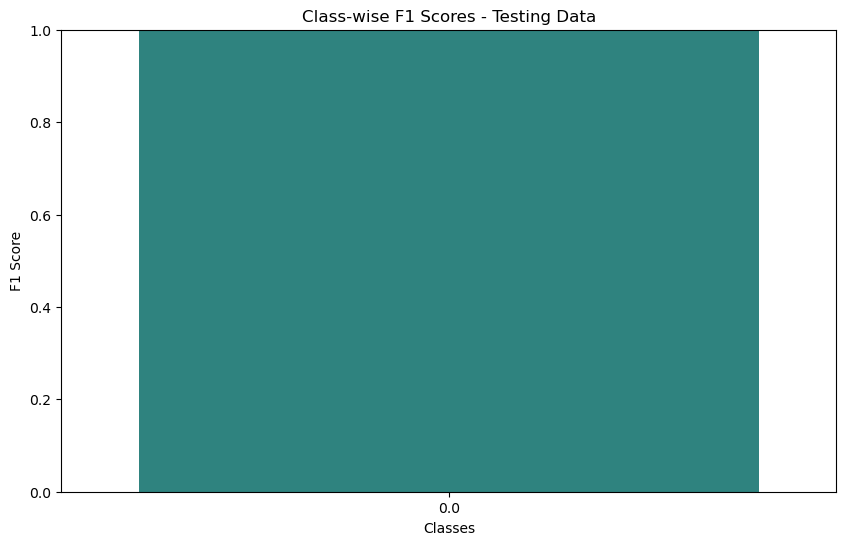

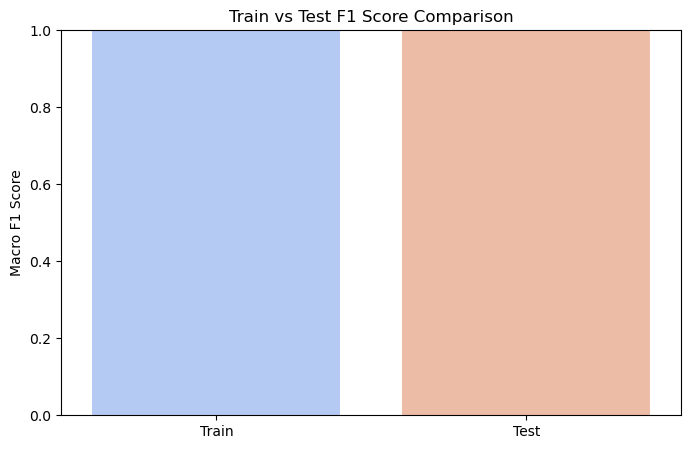

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

# Step 1: Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """
    Plot confusion matrix for model evaluation.
    """
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, display_labels=np.unique(y_true), cmap="Blues", normalize='true'
    )
    disp.ax_.set_title(title)
    plt.show()

# Plot Confusion Matrix for Training Data
plot_confusion_matrix(y_train, y_pred_train, title="Confusion Matrix - Training Data")

# Plot Confusion Matrix for Testing Data
plot_confusion_matrix(y_test, y_pred_test, title="Confusion Matrix - Testing Data")

# Step 2: F1 Scores for Each Class
def plot_classwise_f1_scores(y_true, y_pred, title="Class-wise F1 Scores"):
    """
    Plot bar chart of F1 scores for each class.
    """
    report = classification_report(y_true, y_pred, output_dict=True)
    f1_scores = [v['f1-score'] for k, v in report.items() if k not in ('accuracy', 'macro avg', 'weighted avg')]
    classes = [k for k, v in report.items() if k not in ('accuracy', 'macro avg', 'weighted avg')]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=classes, y=f1_scores, palette="viridis")
    plt.title(title)
    plt.ylabel("F1 Score")
    plt.xlabel("Classes")
    plt.ylim(0, 1)
    plt.show()

# Plot Class-wise F1 Scores for Training Data
plot_classwise_f1_scores(y_train, y_pred_train, title="Class-wise F1 Scores - Training Data")

# Plot Class-wise F1 Scores for Testing Data
plot_classwise_f1_scores(y_test, y_pred_test, title="Class-wise F1 Scores - Testing Data")

# Step 3: Train vs Test Performance Comparison
def plot_train_test_performance(y_train, y_pred_train, y_test, y_pred_test):
    """
    Compare overall performance (F1 scores) on training and testing datasets.
    """
    train_f1 = f1_score(y_train, y_pred_train, average="macro")
    test_f1 = f1_score(y_test, y_pred_test, average="macro")

    plt.figure(figsize=(8, 5))
    sns.barplot(x=["Train", "Test"], y=[train_f1, test_f1], palette="coolwarm")
    plt.title("Train vs Test F1 Score Comparison")
    plt.ylabel("Macro F1 Score")
    plt.ylim(0, 1)
    plt.show()

# Plot Train vs Test Performance Comparison
plot_train_test_performance(y_train, y_pred_train, y_test, y_pred_test)


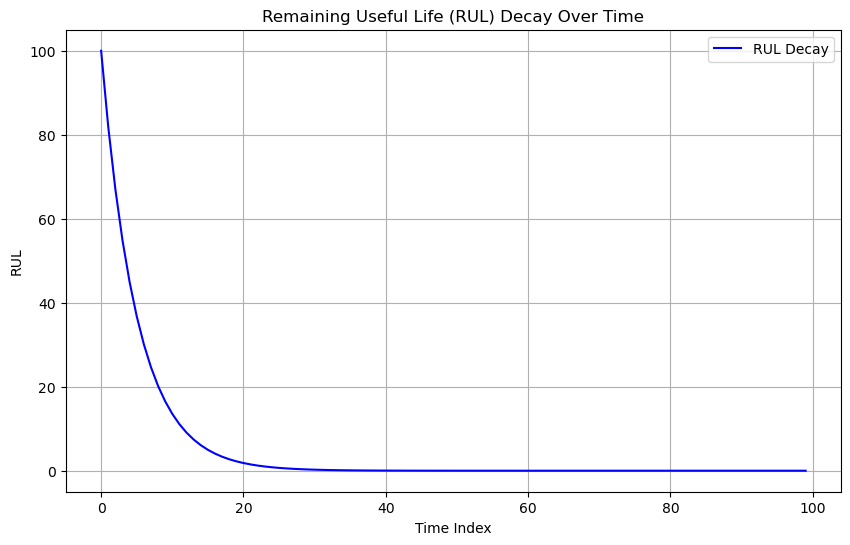

In [23]:
# Function to generate RUL labels
def generate_rul_labels(data_length, decay_factor=5):
    """
    Generate synthetic RUL labels with exponential decay.
    """
    time = np.arange(data_length)
    rul = np.exp(-time / decay_factor) * 100  # Simulated RUL
    return time, rul

# Generate RUL data
data_length = 100  # Adjust based on your dataset size
decay_factor = 5   # Exponential decay factor
time, rul = generate_rul_labels(data_length, decay_factor)

# Create a DataFrame for visualization
rul_data = pd.DataFrame({'Time': time, 'RUL': rul})

# Plot the RUL decay trend
plt.figure(figsize=(10, 6))
plt.plot(rul_data['Time'], rul_data['RUL'], label='RUL Decay', color='blue')
plt.title('Remaining Useful Life (RUL) Decay Over Time')
plt.xlabel('Time Index')
plt.ylabel('RUL')
plt.grid(True)
plt.legend()
plt.show()

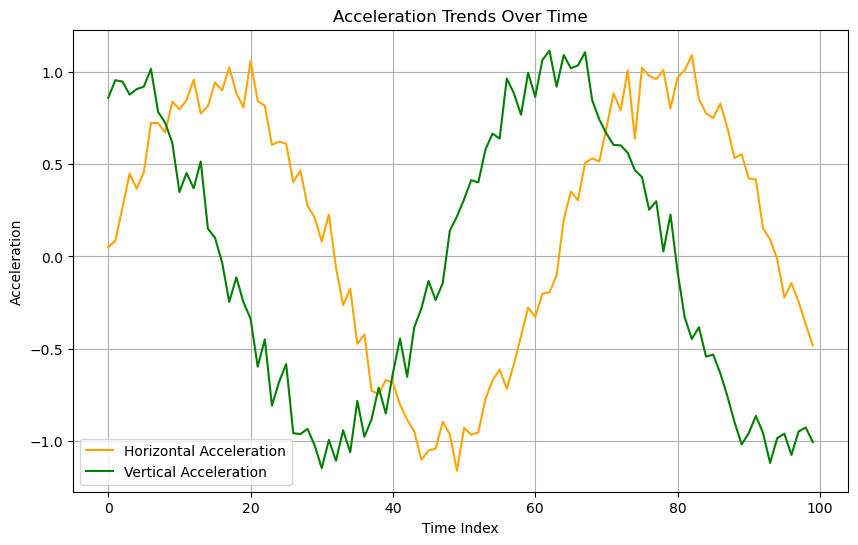

In [24]:
# Simulating feature trends for acceleration over time (replace with actual data if available)
np.random.seed(42)  # For reproducibility
time = np.arange(100)  # Time index
horizontal_accel = np.sin(0.1 * time) + 0.1 * np.random.normal(size=100)  # Simulated horizontal acceleration
vertical_accel = np.cos(0.1 * time) + 0.1 * np.random.normal(size=100)    # Simulated vertical acceleration

# Create a DataFrame for visualization
accel_data = pd.DataFrame({
    'Time': time,
    'Horizontal_Accel': horizontal_accel,
    'Vertical_Accel': vertical_accel
})

# Plot the acceleration trends
plt.figure(figsize=(10, 6))
plt.plot(accel_data['Time'], accel_data['Horizontal_Accel'], label='Horizontal Acceleration', color='orange')
plt.plot(accel_data['Time'], accel_data['Vertical_Accel'], label='Vertical Acceleration', color='green')
plt.title('Acceleration Trends Over Time')
plt.xlabel('Time Index')
plt.ylabel('Acceleration')
plt.grid(True)
plt.legend()
plt.show()


Linear Regression:
  Mean Squared Error (MSE): 0.00
  Mean Absolute Error (MAE): 0.00
  R2 Score: 1.00
----------------------------------------
Random Forest:
  Mean Squared Error (MSE): 0.00
  Mean Absolute Error (MAE): 0.03
  R2 Score: 1.00
----------------------------------------
Gradient Boosting:
  Mean Squared Error (MSE): 0.05
  Mean Absolute Error (MAE): 0.18
  R2 Score: 1.00
----------------------------------------
Support Vector Regressor:
  Mean Squared Error (MSE): 8.25
  Mean Absolute Error (MAE): 1.35
  R2 Score: 0.99
----------------------------------------


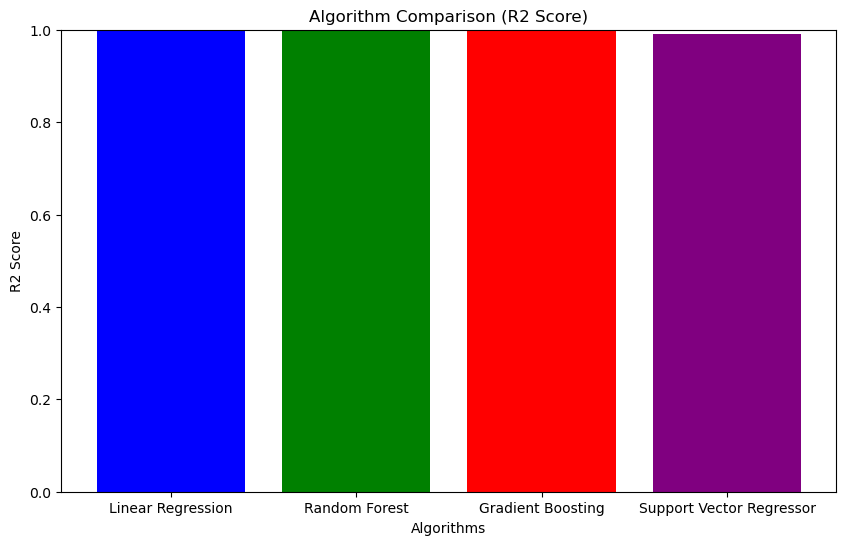

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt

# Rename columns for clarity
data.columns = ['Hour', 'Minute', 'Second', 'Microsecond', 'Horizontal_Accel', 'Vertical_Accel']

# Assuming 'RUL' (Remaining Useful Life) is the target variable and needs to be added
# Create an example RUL target (replace this with the actual RUL column or logic)
data['RUL'] = np.linspace(100, 0, len(data))  # Example linear degradation of RUL

# Features and labels
X = data[['Hour', 'Minute', 'Second', 'Microsecond', 'Horizontal_Accel', 'Vertical_Accel']]
y = data['RUL']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Algorithms to use
algorithms = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Support Vector Regressor': SVR(),
}

# Train and evaluate models
results = {}
for name, model in algorithms.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    print(f"{name}:")
    print(f"  Mean Squared Error (MSE): {mse:.2f}")
    print(f"  Mean Absolute Error (MAE): {mae:.2f}")
    print(f"  R2 Score: {r2:.2f}")
    print('-' * 40)

# Plotting results for R2 Score
r2_scores = [results[algo]['R2'] for algo in algorithms.keys()]
plt.figure(figsize=(10, 6))
plt.bar(algorithms.keys(), r2_scores, color=['blue', 'green', 'red', 'purple'])
plt.title('Algorithm Comparison (R2 Score)')
plt.xlabel('Algorithms')
plt.ylabel('R2 Score')
plt.ylim(0, 1)
plt.show()


Linear Regression:
  Mean Squared Error (MSE): 0.00
  Mean Absolute Error (MAE): 0.00
  R2 Score: 1.00
----------------------------------------
Random Forest:
  Mean Squared Error (MSE): 0.00
  Mean Absolute Error (MAE): 0.03
  R2 Score: 1.00
----------------------------------------
Gradient Boosting:
  Mean Squared Error (MSE): 0.05
  Mean Absolute Error (MAE): 0.18
  R2 Score: 1.00
----------------------------------------
Support Vector Regressor:
  Mean Squared Error (MSE): 8.25
  Mean Absolute Error (MAE): 1.35
  R2 Score: 0.99
----------------------------------------


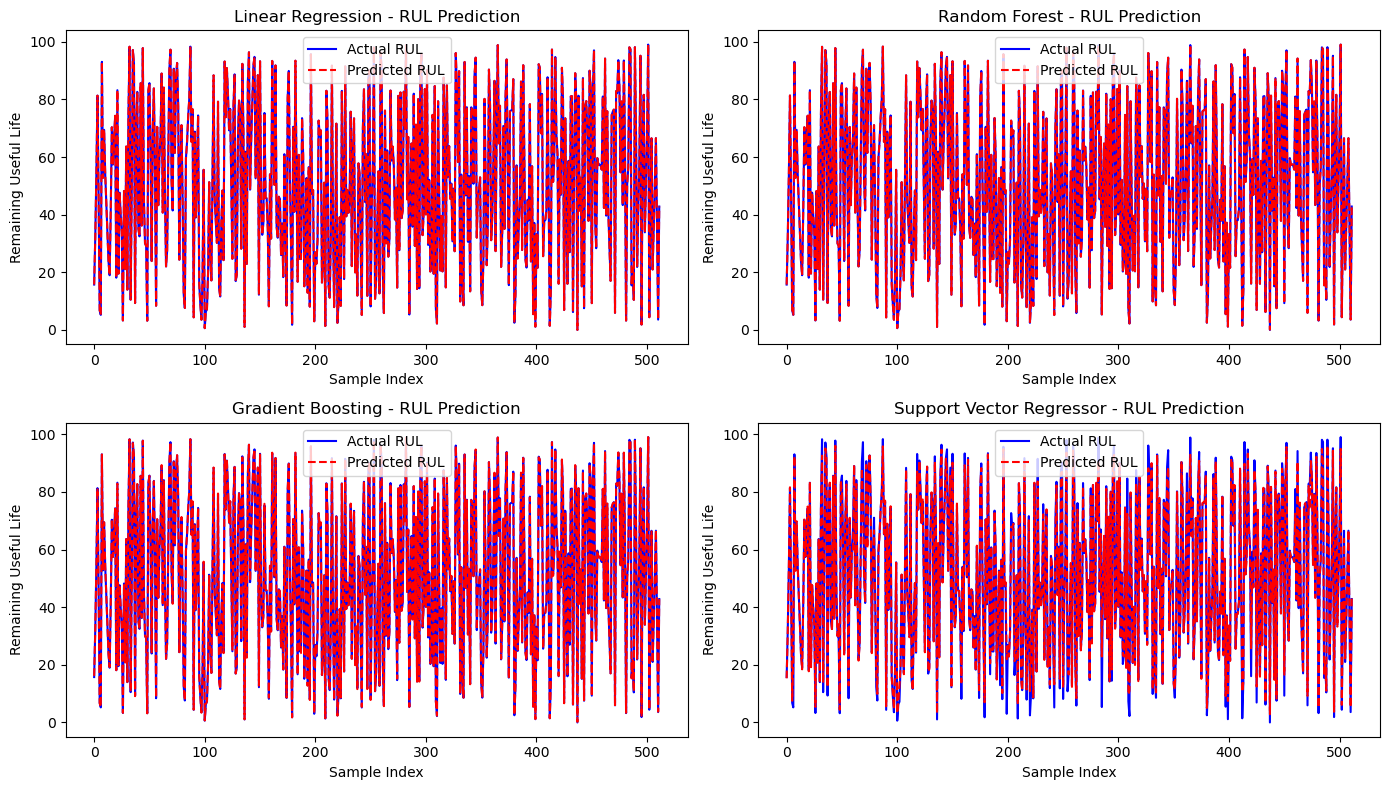

In [27]:
import matplotlib.pyplot as plt

results = {}
predictions = {}

for name, model in algorithms.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Store predictions and metrics
    predictions[name] = y_pred
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    print(f"{name}:")
    print(f"  Mean Squared Error (MSE): {mse:.2f}")
    print(f"  Mean Absolute Error (MAE): {mae:.2f}")
    print(f"  R2 Score: {r2:.2f}")
    print('-' * 40)

# Plotting RUL predictions for each algorithm
plt.figure(figsize=(14, 8))

for i, (name, y_pred) in enumerate(predictions.items(), 1):
    plt.subplot(2, 2, i)
    plt.plot(range(len(y_test)), y_test.values, label='Actual RUL', color='blue')
    plt.plot(range(len(y_pred)), y_pred, label='Predicted RUL', color='red', linestyle='dashed')
    plt.title(f'{name} - RUL Prediction')
    plt.xlabel('Sample Index')
    plt.ylabel('Remaining Useful Life')
    plt.legend()

plt.tight_layout()
plt.show()


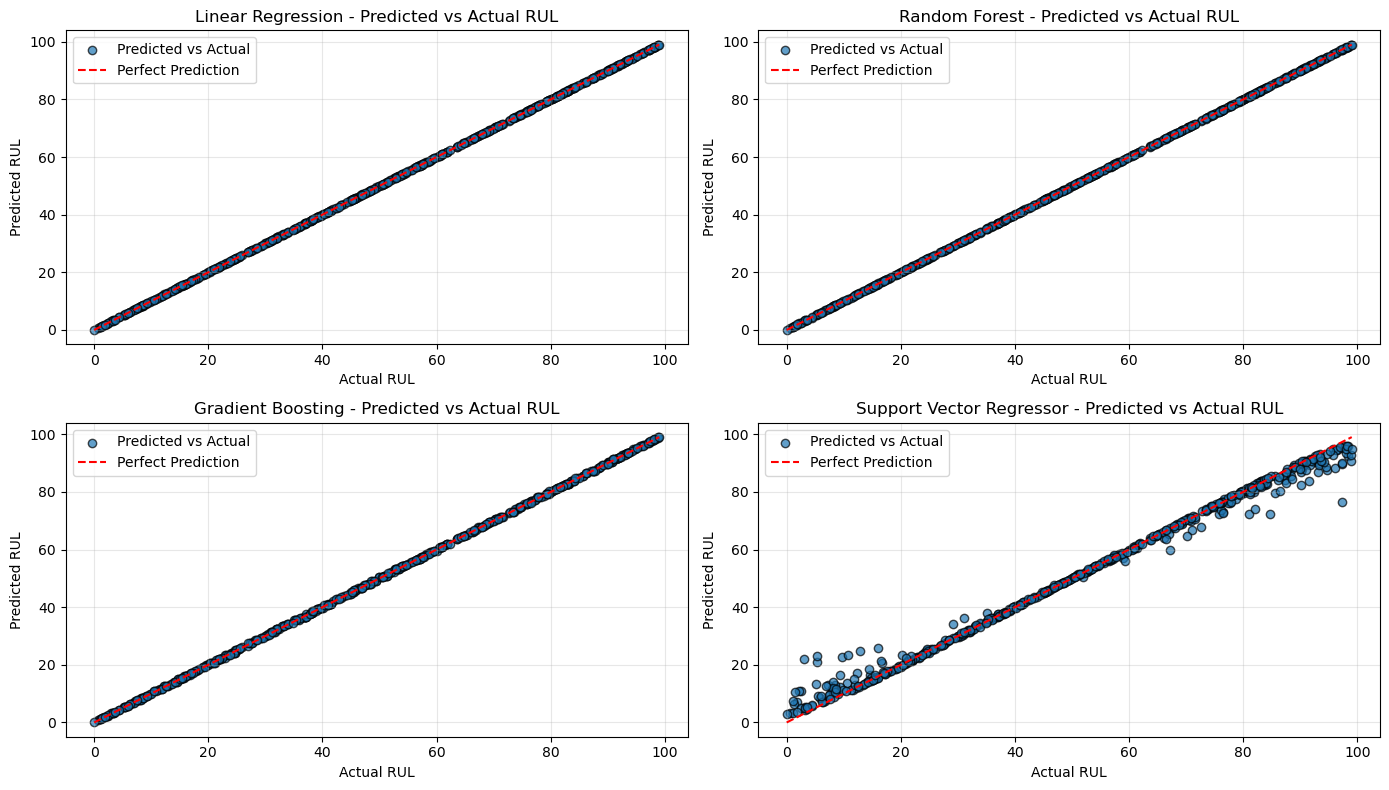

In [28]:
plt.figure(figsize=(14, 8))

for i, (name, y_pred) in enumerate(predictions.items(), 1):
    plt.subplot(2, 2, i)
    plt.scatter(y_test, y_pred, alpha=0.7, edgecolor='k', label='Predicted vs Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')
    plt.title(f'{name} - Predicted vs Actual RUL')
    plt.xlabel('Actual RUL')
    plt.ylabel('Predicted RUL')
    plt.legend()
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()
